# Day 2: A python class example
Date: 01/05/2022
Author: Lucy Hackett

Goal: Introduce OLS as a minimum-distance estimator. We will:
- write a very simple class example, explaining instantiation, methods, and scope
- give a brief explanation of the scipy.optimize.minimize function
- show how to pull from random distributions
- create and plot x, y data
- make a linear projection function with b0, b1, x as input, y as output
- minimize the squared errors to estimate b0 and b1
- create a class that implements the same minimization, 
  that takes data in instantiation, and has an 'estimate' method.

In [4]:
# for later
import numpy as np

## Introduction to python classes
python classes are objects that have attributes and methods. These objects are abstract in the sense that a class in the abstract is used to "instantiate" specific "instances" of the class. For example, here we will create a class called Student, and will create several instantiations of specific students.

To define a class, we use ``class ClassName:``, followed by indented lines (convention is to name classes with upper case).

Classes have 3 components:
* **The constructor** this is a method (think: function) that creates an _instance_ of the class. This component must be present in all classes, as it is the engine that creates the object. It looks like ``def __init__(self)``
* **Attributes** These are atributes that all instances of a class have. They can be anything, or not exist at all. For example, in a Student class, we might want student's to have attributes like a student ID, gender, age, etc. These can vary by instance of the Student class, but all isntances of ``Student`` have one. 
* **Methods** Methods are functions that belong to a class. They may return output or not. For example, we may want to write a method that calculates the student's GPA given a series of numeric grades.

The most simple class is made up of only a constructor, and the most simple constructor doesn't do anything except create an instance of the class. This looks like:

In [1]:
class Student:
    def __init__(self):
        # print something just to show the instance is created
        # we don't even need this; we could also just type:
        # pass
        print("I made a student!") 

In [2]:
# notice how the constructor method is executed when I call Student(),
# as evidenced by the fact that the print() runs
luisa = Student()

I made a student!


In [3]:
# Luisa is a Student
luisa

Now let's (re)make this class more interesting by adding attributes. Attributes can be passed into the instance of the object by defining the constructor as a function of the arguments we want to pass in. Let's pass in the following attributes:
* name (a ``string``)
* grades (a ``numpy array`` of numbers)
* age

We do this by defining these attributes with ``self.attribute =`` in the constructor function:

In [5]:
class Student:
    def __init__(self, name, grades, age):
        self.name = name
        self.grades = grades
        self.age = age

In [10]:
# create an instance of the class:
luisa = Student("Luisa", np.array([4.0, 3.5, 3.0]), 28)
armond = Student("Armand", np.array([3.0, 3.5, 3.0]), 23)
# we can access thse attributes using the .:
print(luisa.grades)
print(armond.grades)

[4.  3.5 3. ]
[3.  3.5 3. ]


Finally, we add in methods. Methods (usually) go _outside the constructor environment_ (unindented), as they are not created when the instance is created but rather called later. Because these "belong" to the class just like attributes do, we call these methods using ``instanceName.methodName()`` similar to how attributes are also accessed using ``.``. Let's write two simple methods:
* A method that takes as an input a greeting phrase and prints ``_____, [instance name]!``.
* A method that returns the student's GPA

Note a couple things about the method below:
* class methods are defined with ``self`` as the first argument, but this argument is omitted when the method is called.
* Because ``self`` is passed to the methods, these have access to any methods and attributes that belong to the class.

In [14]:
class Student:
    def __init__(self, name, grades, age):
        self.name = name
        self.grades = grades
        self.age = age
        
    def greeting(self, phrase):
        print(phrase+', '+self.name+'!')
        
    def gpa(self):
        return(np.mean(self.grades))

In [15]:
luisa = Student("Luisa", np.array([4.0, 3.5, 3.0]), 28)

In [16]:
# call the greeting method
luisa.greeting("Ahoy")

Ahoy, Luisa!


In [17]:
# calculate Luisa's GPA:
gpa = luisa.gpa()
print(gpa)

3.5

FIXME: What should we add about scope?

## Python classes in the wild: Random numbers

Now that we have seen the basic functionality of python classes, you will notice that classes are **everywhere**. While python is not explicitly an objecct-oriented language, i.e., a language designed to work with abstract objects like classes, many, many python packages are build around classes. 

A nearby example are random variable distributions from the ``scipy.stats`` module. These distributions are actually themselves instances of a class called ``rv_continuous``

In [19]:
from scipy.stats import distributions as iid

In [20]:
# instantiate a normal distribution
# note that passing arguments into the instantiation here is not
# necessary; that is because there are default values for attributes
# such as the mean and variance (sufficient statistics for this dist.)
x = iid.norm()

In [24]:
# access an attribute: random state
# (used to generate random numbers)
x.random_state

RandomState(MT19937) at 0x7F978018F270

In [25]:
# access a method: get the mean
x.mean()

0.0

In [26]:
# another method: generate random numbers using the rvs() method
x.rvs(5)

array([-0.84044792,  0.59675202,  1.31426983,  0.61845329, -0.82903949])

In [27]:
# note that we can create more instances with different attributes:
x5 = iid.norm(loc=5)
x5.mean()

5.0

## Exercise
Use ``scipy.stats`` distributions to generate 2 vectors ``x`` and ``y``. Try and read the documentation for the gamma distribution [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) to make one of these vectors distributed $\Gamma(a), a > 0$. The documentation for the normal distribution if you want to play with that is [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm).

Plot these against eachother.

In [29]:
# Step 1: instantiate

# y distributed normal (5,5)
y = iid.norm(loc=5,scale=5)
# x dist. gamma(a)
a = 2
x = iid.gamma(a)

In [30]:
# Step 2: generate random numbers
N = 100
y_draw = y.rvs(N)
x_draw = x.rvs(N)

Text(0, 0.5, 'Y')

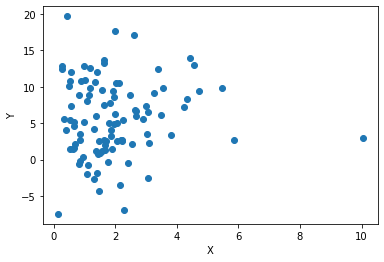

In [34]:
# extra: plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(x_draw, y_draw)

ax.set_xlabel("X")
ax.set_ylabel("Y")

## Building blocks of an OLS class
Now, before defining the OLS class methods, we are going to write its methods first outside the class so that we know they are behaving properly. Our goal is to write 2 main methods:
1. Linear projection
    - inputs: b0, b1, x
    - outputs: y
2. Minimizer function: minimizes the squared distance between the linear projection and y

### 1. Linear projection
Suppose we have a vector X that is N by 2, where the first column is a column of ones, and a vector of betas: b = [b0, b1]. The projection matrix, or the matrix that predicts y, is given by $Xb$.

In [35]:
def linear_projection(X, b):
    return X@b

In [52]:
# test our function
N = 100

# note I instantiate iid.norm() and call method rvs() in the same step!
X = np.vstack((np.ones(N), iid.norm().rvs(N))).T
# we don't need y yet but let's make it for later
y = iid.norm(loc=2).rvs(N).reshape((N,1))
b = np.array([2,7]).reshape(2,1)

# look at the first 5 entries
linear_projection(X, b)[:5]

array([[ 1.97768266],
       [ 5.90864822],
       [ 5.82293348],
       [-8.23797788],
       [15.70418132]])

### 2. Minimizer function
In order to minimize, we are going to use a minimizer function from ``scipy.optimize``. The documentation for this function can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html), but the key arguments are the following:
* ``fun``: the function to be minimized. This must be a function of only one input; if there are multiple inputs, we will "mask" these using lambda functions.
* ``x0``: The start guess for the solution. In the case that the solution has a global minimum (as the least squares problem does) the choice will only affect computation time.

The function returns an instance of the ``OptimizeResult`` class, which has several attributes. The only one we will be interested in for now is ``x``, the solution that solves the minimization.

Let's set up a function that returns the object we want to minimize: the sum of squared errors:

In [55]:
def sse(y, X, b):
    yhat = linear_projection(X, b)
    sse = np.sum((yhat - y)**2)
    return sse

Now we can minimize this function, making it a function of just one variable by masking the other inputs in a lambda function:

In [57]:
from scipy.optimize import minimize

In [60]:
minimize(lambda b: sse(y, X, b), x0 = [0,0])
# as expected, we get an intercept of around 2 and a slope around 0

      fun: 10873.725596765391
 hess_inv: array([[5.03788452e-05, 4.93170075e-06],
       [4.93170075e-06, 6.42009481e-05]])
      jac: array([ 0., -0.])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([ 1.86817651e+00, -1.33989881e-09])

## Creating an OLS class
Now let's take our functions and organize them into an OLS class. This class will have attributes X and y, and methods defined by the functions above.

In [67]:
class OLS:
    # constructor
    def __init__(self, X, y):
        # define attributes
        self.X = X
        self.y = y
    
    ##### methods
    # linear projection
    def linear_projection(self, b):
        return self.X@b
    # SSE
    def sse(self, b):
        yhat = linear_projection(self.X, b)
        sse = np.sum((yhat - self.y)**2)
        return sse
    # minimize the SSE
    def estimate(self, x0 = [0,0]):
        sol = minimize(lambda b: sse(self.y, self.X, b), x0 = x0)
        return sol.x

In [68]:
# instantiate model
model1 = OLS(X, y)

In [69]:
# call the solve_OLS() method
model1.estimate()

array([ 1.86817651e+00, -1.33989881e-09])